# Занятие 6. Обучение без учителя. Поиск аномалий

**Зачем?** Дело в том, что размеченные данные поступают не всегда. Более того, иногда объектов одного класса очень мало (5-6 штук), а иногда и вообще нет. Тем не менее, на имеющихся неразмеченных данных хочется обучать алгоритмы, способные в дальнейшем нетипичные объекты тестовой выборки (аномалии) распознать

## Загрузка данных
[Данные](http://odds.cs.stonybrook.edu/thyroid-disease-dataset/) представляют собой список пациентов с больной и здоровой щитовидной железой

In [1]:
from scipy.io import loadmat
data = loadmat('data/thyroid.mat')
X, y = data['X'], data['y']
X.shape, y.shape

((3772, 6), (3772, 1))

Сожмём 6 признаков до 2 (нужно исключительно для дальнейшей визуализации

In [2]:
from sklearn.manifold import TSNE

X_emb = TSNE(n_components=2).fit_transform(X)

In [3]:
X_emb.shape

(3772, 2)

Всё сжалось до 2 признаков

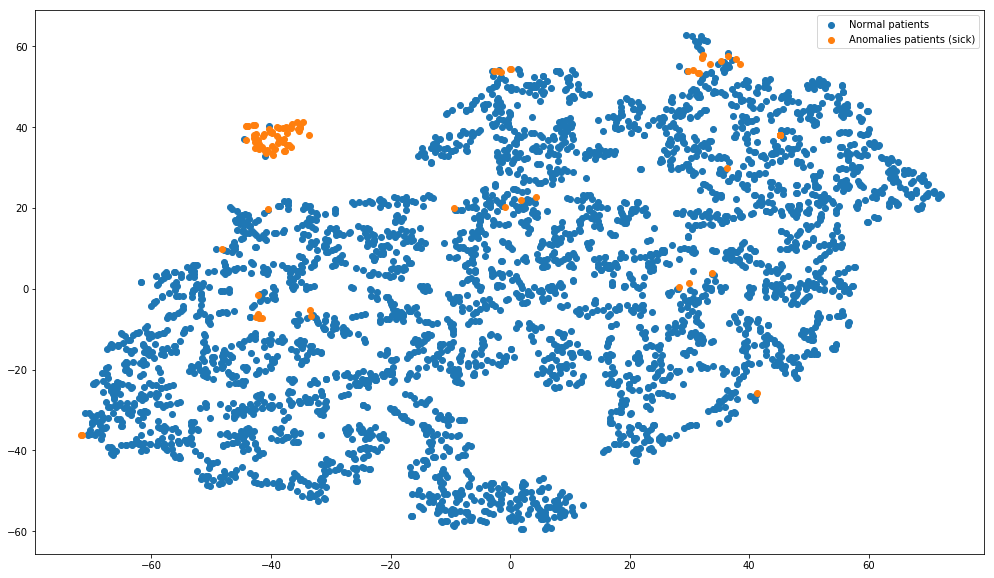

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(17,10))
normals_idx = np.argwhere(y == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb[normals_idx, 0], X_emb[normals_idx, 1], label='Normal patients')
plt.scatter(X_emb[anomalies_idx, 0], X_emb[anomalies_idx, 1], label='Anomalies patients (sick)')
plt.legend()

In [5]:
from sklearn.cross_validation import train_test_split
X_emb_train, X_emb_test, X_train, X_test, y_train, y_test = train_test_split(X_emb, X, y, train_size=0.8)

/home/artem/anaconda3/envs/pytorch_3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Детектирование аномалий

![](https://alexanderdyakonov.files.wordpress.com/2017/04/outlier_detection2.jpg)

Строго говоря, в анализе данных есть два направления, которые занимаются поиском аномалий: детектирование выбросов (Outlier Detection) и «новизны» (Novelty Detection). Как и выброс «новый объект» — это объект, который отличается по своим свойствам от объектов (обучающей) выборки.  Но  в отличие от выброса, его в самой выборке пока нет (он появится через некоторое время, и задача как раз и заключается в том, чтобы обнаружить его при появлении). Например, если вы анализируете замеры температуры и отбрасываете аномально большие или маленькие, то Вы боретесь с выбросами. А если Вы создаёте алгоритм, который для каждого нового замера оценивает, насколько он похож на прошлые, и выбрасывает аномальные — Вы «боретесь с новизной».

## 1. Статистический тест

Как правило, применяют для отдельных признаков и отлавливают экстремальные значения (Extreme-Value Analysis). Для этого используют, например, Z-value или Kurtosis measure.

![](https://alexanderdyakonov.files.wordpress.com/2017/04/kurtosis2.png)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[np.argwhere(y_train == 1)[:,0]]) # обучим scaler только на хороших данных
X_transform = scaler.transform(X_test) # наши Z-value (это преобразование можно использовать для нормировки данных)

In [7]:
X_transform.shape

(755, 6)

Теперь можно по правилу 3 сигм (можно и любой другой уровень значимости выбрать) выявить объекты-выбросы, Z-value которых выходить за допустимый интервал

In [8]:
preds = (X_transform < -3).astype(np.uint8).sum(axis=1) + (X_transform > 3).astype(np.uint8).sum(axis=1) # массив булевых значений. True - если выброс, False
y_test[preds > 0].mean(), y_test.mean()

(0.0033783783783783786, 0.02913907284768212)

Видим, что среди выбросов доля "Status 2" (невозвращенных кредитов) выше 

In [9]:
y_pred = (preds > 4).astype(np.uint8) # получим предсказания. Т.к. y_pred - 1 или 2, а outlier_indices.astype(np.uint8) - 0 или 1 (1 - выброс, 0 - нет), то добавим 1

from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.9708609271523179

Точность классификации получилась 69%! Это при том, что это обучение без учителя, т.е. мы вообще никак не использовали правильные ответы!

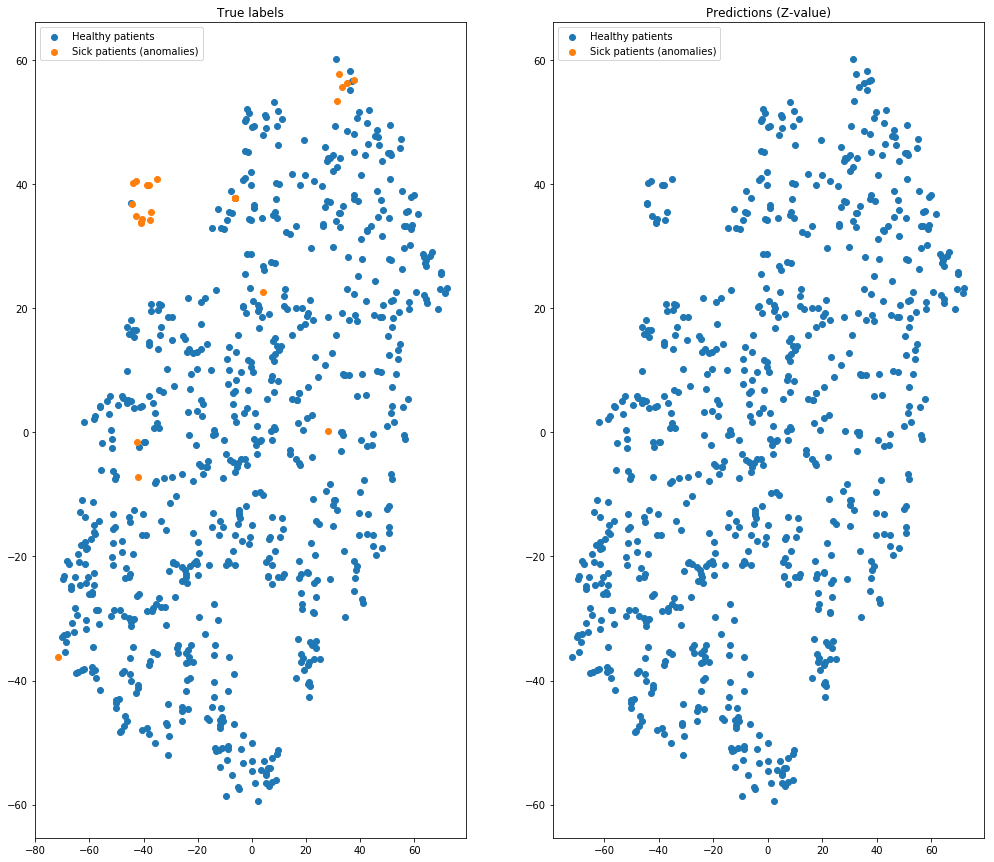

In [10]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
normals_idx = np.argwhere(y_test == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_test == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

plt.subplot(122)
plt.title('Predictions (Z-value)')
normals_idx = np.argwhere(y_pred == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_pred == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

### Резюме
**Плюсы:**
* Никакого машинного обучения :) Z-value - чисто статистический тест
* Быстрый
* Простой
* Возможность на одних данных обучать, к другим - применять

**Минусы:**
* На сложных данных может не работать

**Специфика применения:** простые выбросы и новизна

## 2 Local outlier factor
[Local outlier factor](https://en.wikipedia.org/wiki/Local_outlier_factor) очень похож на метод ближайших соседей, только без учителя. Вот как он работает:

![](https://alexanderdyakonov.files.wordpress.com/2017/04/fig2_nns.png)

На рис. выше считается расстояние от каждого объекта до ближайшего соседа, определённым образом нормируется и полученная величина тем выше, чем больше вероятность аномалии. Результат получается примерно такой:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/59/LOF.svg/600px-LOF.svg.png)

In [11]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=10)
y_pred = clf.fit_predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 1, а +1 перешла в 0

accuracy_score(y_pred, y_test)

/home/artem/anaconda3/envs/pytorch_3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.9178807947019868

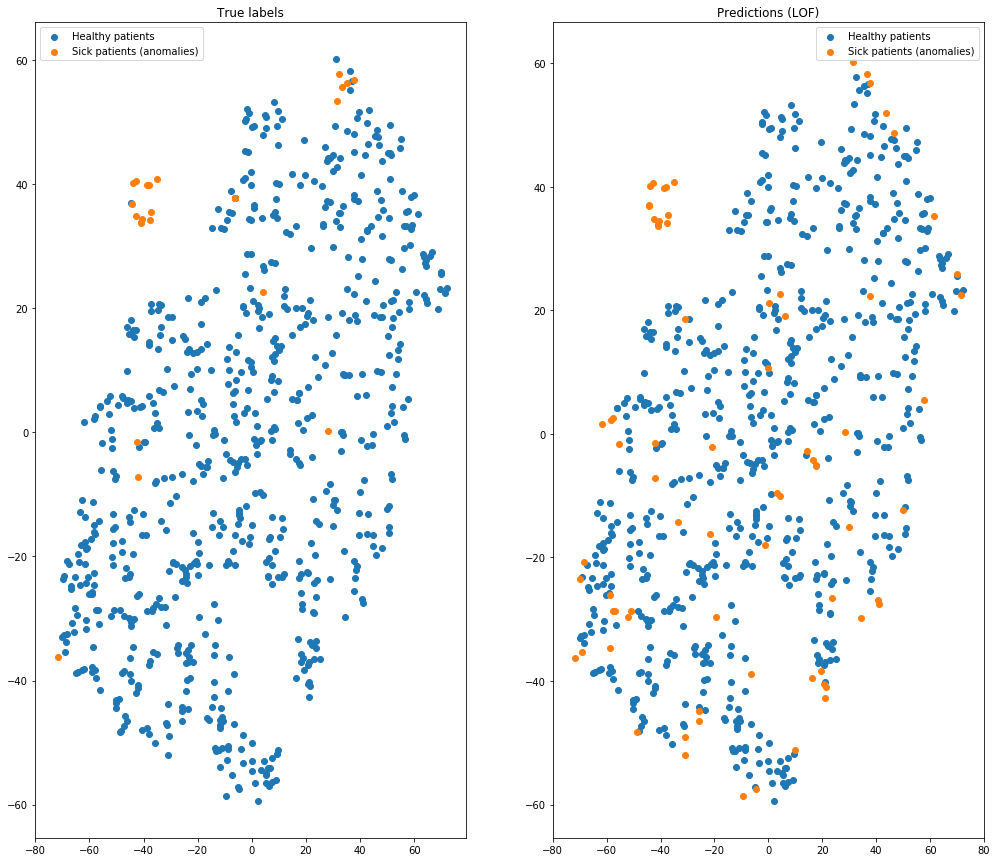

In [12]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
normals_idx = np.argwhere(y_test == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_test == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

plt.subplot(122)
plt.title('Predictions (LOF)')
normals_idx = np.argwhere(y_pred == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_pred == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

Видим, как LOF хорошо определил выбросы

### Резюме
**Плюсы:**
* Понятный

**Минусы:**
* Медленный
* Нет возможности обучиться на одних данных, а получить предсказания для других. Есть только метод .fit_predict()


**Специфика применения:** выбросы и новизна

**Что можно улучшить:**
* Погридсёчить параметры

## 3. Методы машинного обучения
![](https://alexanderdyakonov.files.wordpress.com/2017/04/fig_all.png?w=1024)

## 3.1 One-Class SVM
Основная идея - построить такую минимальную оболочку вокруг обучающей выборки, которая полностью бы содержала объекты обучающей выборки

![](http://rvlasveld.github.io/images/oc-svm/visualization.gif)

In [13]:
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline

clf = Pipeline([('scaler', StandardScaler()), ('estimator', OneClassSVM())])
clf.fit(X_train[np.argwhere(y_train == 0)[:, 0]]) # покажем модели, как выглядят здоровые пациенты
y_pred = clf.predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 1, а +1 перешла в 0

accuracy_score(y_pred, y_test)

0.48874172185430464

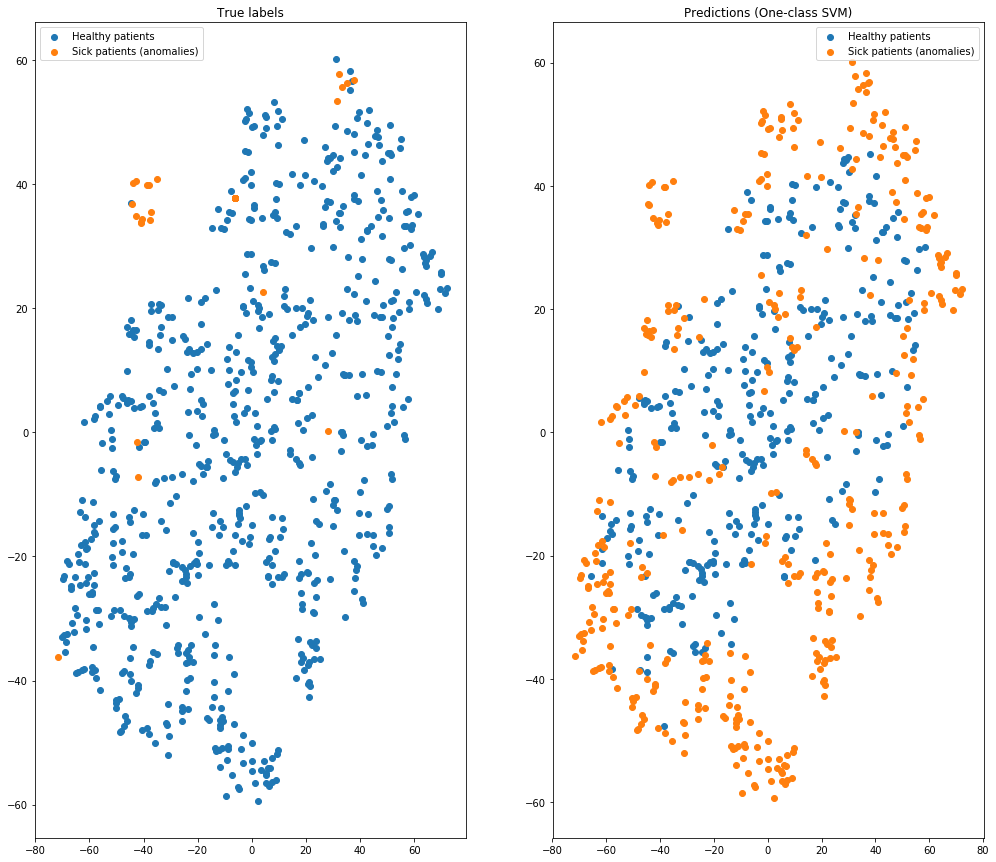

In [14]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
normals_idx = np.argwhere(y_test == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_test == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

plt.subplot(122)
plt.title('Predictions (One-class SVM)')
normals_idx = np.argwhere(y_pred == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_pred == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

### Резюме
**Плюсы:**
* Эффективный
* Намного быстрее LOF (KNN)
* Можно обучать на одних данных (например, только хороших), а применять к другим

**Минусы:**
* На очень больших данных работает долго (когда миллионы объектов)
* Плохо выявляет сложные зависимости
* Очень плохо работает с не RBF-ядрами

**Что можно улучшить:**
* Погридсёчить параметры


**Специфика применения:** только новизна и сильные выбросы

## 3.2 IsolationForest
Идея IsolationForest - определить номер объекта с помощью решающих правил. Казалось бы, что это очень похоже на переобучение, однако такой подход имеет интересные свойства: оказывается, что таким деревьям аномальные объекты и выбросы гораздо легче отделить от выборки с помощью правил, поскольку его сложно спутать с остальными объектами! Это тот случай, когда переобучение идёт нам на руку!

![](https://alexanderdyakonov.files.wordpress.com/2017/04/fig_forest.png)

In [15]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=y_train.mean())
clf.fit(X_train) # покажем нашей модели, как выглядят наши пациенты
y_pred = clf.predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 1, а +1 перешла в 0

accuracy_score(y_pred, y_test)

/home/artem/anaconda3/envs/pytorch_3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/artem/anaconda3/envs/pytorch_3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.9721854304635762

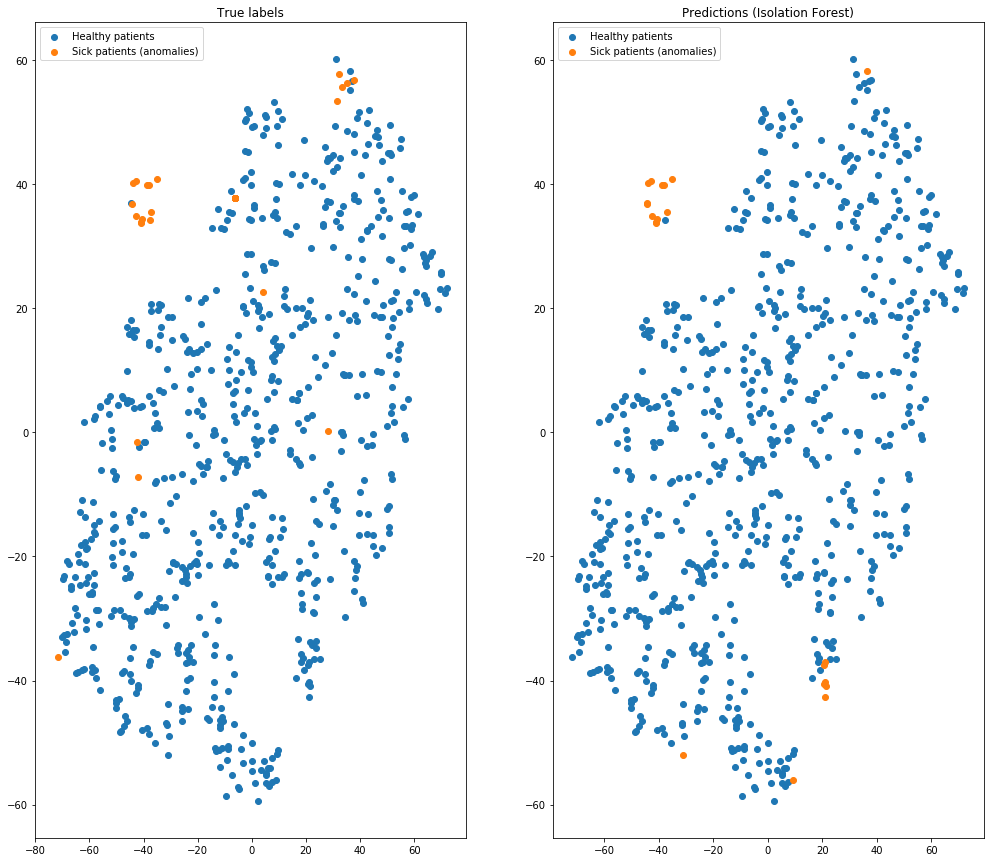

In [16]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
normals_idx = np.argwhere(y_test == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_test == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

plt.subplot(122)
plt.title('Predictions (Isolation Forest)')
normals_idx = np.argwhere(y_pred == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_pred == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

### Резюме
**Плюсы:**
* Способен выявлять сложные закономерности
* Можно обучать на одних данных, а применять - к другим
* Быстрый и масштабируемый

**Минусы:**
* Склонен к переобучению

**Что можно улучшить:**
* Погридсёчить параметры

**Специфика применения:** - выбросы и новизна

## 3.3 EllipticEnvelope
Подход похож на One-class SVM, только "оборачивает" обучающую выборку выпуклой эллиптической оболочкой

In [17]:
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope()
clf.fit(X_train[np.argwhere(y_train == 0)[:,0]]) # покажем нашей модели, как выглядят здоровые пациенты
y_pred = clf.predict(X_test) # возвращает предсказания {-1, 1}. -1 - аномалия
y_pred = (1 - y_pred) / 2 # нормируем так, чтобы -1 перешла в 1, а +1 перешла в 0

accuracy_score(y_pred, y_test)

/home/artem/anaconda3/envs/pytorch_3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.895364238410596

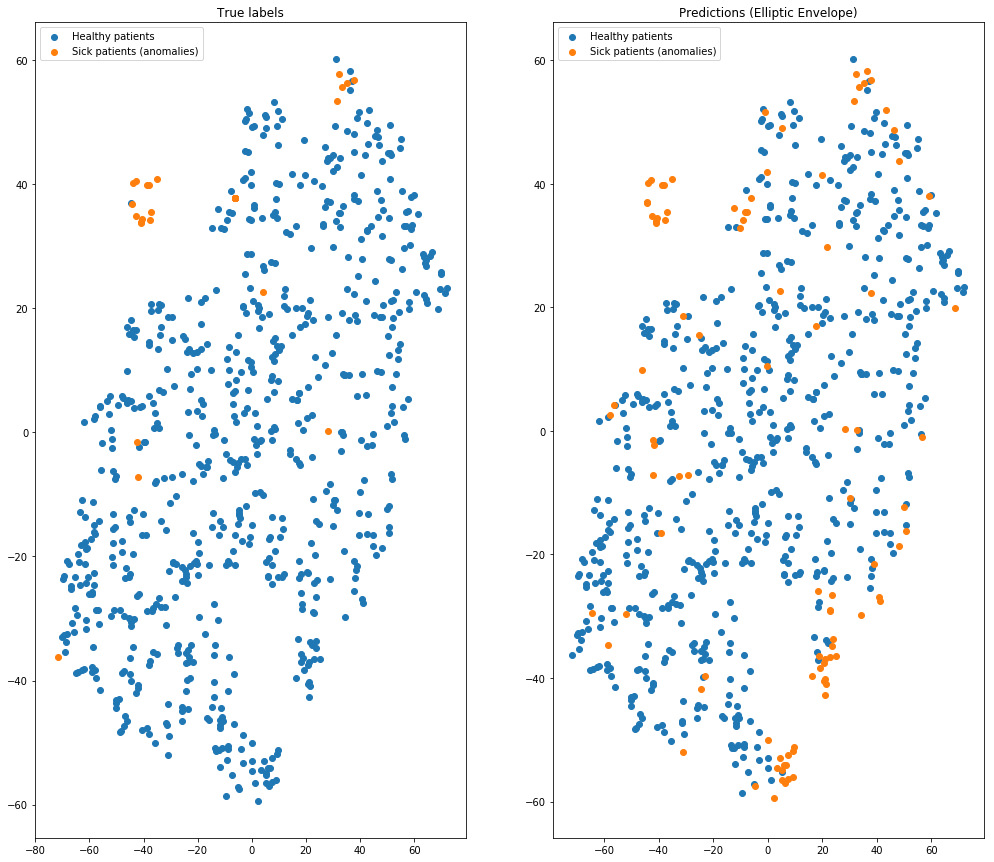

In [18]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
normals_idx = np.argwhere(y_test == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_test == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

plt.subplot(122)
plt.title('Predictions (Elliptic Envelope)')
normals_idx = np.argwhere(y_pred == 0).squeeze() # позиции здоровых пациентов
anomalies_idx = np.argwhere(y_pred == 1).squeeze() # позиции больных пациентов
plt.scatter(X_emb_test[normals_idx, 0], X_emb_test[normals_idx, 1], label='Healthy patients')
plt.scatter(X_emb_test[anomalies_idx, 0], X_emb_test[anomalies_idx, 1], label='Sick patients (anomalies)')
plt.legend()

### Резюме
**Плюсы:**
* Простой
* Быстрый

**Минусы:**
* Плохо работает на сложных данных

**Что можно улучшить:**
* Погридсёчить параметры

**Специфика применения:** только новизна и сильные выбросы

# Полезные ссылки
* [Поиск аномалий в данных](https://alexanderdyakonov.wordpress.com/2017/04/19/поиск-аномалий-anomaly-detection/)